# Exercise 1: Parameter Counting and Memory Management (30 points)

Show your work for the following short-answer questions.

## part 1(a) Parameter counting (10 points)

A more advanced version of the CNN we trained may have three convolutional layers, each with $3 \times 3$ kernels, a stride of 2, and "same" padding.
The lowest (first) `Conv2D` layer outputs 100 feature maps, the middle layer outputs 200, and the top (last) one outputs 400 maps.
These operate on input images that are RGB images of $200 \times 300$ pixels.

Show that this network will comprise more than 800,000 parameters.

## part 1(b) Memory management (10 points)

The parameters in part 1(a) are typically represented using 32-bit floating point numbers.
Show that this network will require at least 12 MB of RAM when making a *prediction* for a single data instance (input image).

## part 1(c) Memory management in training(5 points)

How much RAM is needed if mini-batch *training* is used with batches of 50 images? (*Hint*: it is at least 500 MB.)

## part 1(d) RNN dimensions (5 points)

The input to an RNN layer must have three dimensions.
What does each input dimension represent?
And what do the outputs of the RNN layer represent?

In [61]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### ========
### **Work for Exercise 1**

#### Part 1(a): Parameter Counting


*Given CNN Architecture:*
- Input: RGB images (3 channels), 200×300 pixels
- Conv2D Layer 1: 3×3 kernels, stride=2, 'same' padding → 100 feature maps
- Conv2D Layer 2: 3×3 kernels, stride=2, 'same' padding → 200 feature maps  
- Conv2D Layer 3: 3×3 kernels, stride=2, 'same' padding → 400 feature maps

*Parameter Calculation:*

Layer 1: Input channels = 3, Output channels = 100
  - Weights: (3×3 kernel) × (3 input) × (100 output) = 9 × 3 × 100 = 2,700
  - Biases:  100
  - Total Layer 1: 2,700 + 100 = **2,800 parameters**

Layer 2: Input channels = 100, Output channels = 200
  - Weights: (3×3 kernel) × (100 input) × (200 output) = 9 × 100 × 200 = 180,000
  - Biases:  200
  - Total Layer 2: 180,000 + 200 = **180,200 parameters**

Layer 3: Input channels = 200, Output channels = 400
  - Weights: (3×3 kernel) × (200 input) × (400 output) = 9 × 200 × 400 = 720,000
  - Biases:  400
  - Total Layer 3: 720,000 + 400 = **720,400 parameters**

TOTAL PARAMETERS: 2,800 + 180,200 + 720,400 = **903,400 parameters**

--> MORE THAN 800,000 parameters

#### Part 1(b): Memory Management

*Memory Calculation for Single Image Prediction:*

Parameters: 
- 903,400 parameters × 32 bits/parameter = 28,908,800 bits

- 28,908,800 / 8 = 3,613,600 bytes (8 bits = 1 byte)

- 3,613,600 / (1024²) ≈ **3.45 MB** (1024 byte = 1 KB; 1024 KB= 1 MB)

---

*Activations (intermediate feature maps):*

Input: 200 × 300 × 3 = 180,000 values
- After Layer 1 (stride=2): 100 × 150 × 100 = 1,500,000 values
- After Layer 2 (stride=2): 50 × 75 × 200 = 750,000 values
- After Layer 3 (stride=2): 25 × 38 × 400 = 380,000 values (approximately)

Total activations: 180,000 + 1,500,000 + 750,000 + 380,000 ≈ 2,810,000 values

At 32 bits each: 2,810,000 × 32 / 8 / (1024²) ≈ **10.72 MB**

TOTAL RAM for single prediction:
- Parameters: 3.45 MB
- Activations: 10.72 MB
- TOTAL: ≈ **14.17 MB**

--> AT LEAST 12 MB (actually ~14 MB).


#### Part 1(c): Memory Management in Training

Mini-Batch Training with batch_size = 50:

Memory components:

- Activations for 50 images: 50 × 10.72 MB ≈ 536 MB
- Activation Gradients: 50 × 10.72 MB ≈ 536 MB

TOTAL: ≈ **1,072 MB ≈ 1.07 GB**

-> AT LEAST 500 MB

#### Part 1(d): RNN Dimensions

RNN Input Dimensions: (batch_size, sequence_length, feature_size)

- Batch Size: Number of sequences processed at once
- Sequence Length: Number of steps in sequence
- Input Size: Dimension of the input at each step  

RNN Outputs Represent:
- Learned information of the sequence up to that point

# Exercise 2: CNN Training for Quantum State Classification (35 points)

In this exercise you will train a CNN on a dataset of quantum states for a particle in a 1-d box of length $L$.

The goal is to identify the quantum index of the eigenfunction: $n=1,2,3,\ldots$, or the dominant eigenfunction for a mixed state.

*Bonus question: why is the CNN a better choice for this challenge than a RNN?*



## Generate dataset

We give you the dataset generator so that everyone has a similar dataset.

The basic spatial eigenfunction is
$\psi(x) = \sqrt{\frac{2}{L}} \sin(n\pi x/L),$
but that is too simple to learn, so we add some Gaussian noise to the function to make it challenging.

In [62]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

np.random.seed(42)
torch.manual_seed(42)

# Parameters for the simulation
NUM_POINTS = 256          # points in the spatial function
NUM_CLASSES = 5           # quantum numbers n = 1 through 5
NOISE_STD = 0.3               # std of Gaussian noise to add

def generate_noisy_pinb(n_samples, noise_std=NOISE_STD, L=1.0):
    """Generate noisy wavefunctions for Particle In Box
       with known box length L."""
    x = np.linspace(0, L, NUM_POINTS, endpoint=False)
    X = np.zeros((n_samples, NUM_POINTS))
    y = np.zeros(n_samples, dtype=int)
    for i in range(n_samples):
        n = np.random.randint(1, NUM_CLASSES + 1)          # n = 1…5
        psi = np.sqrt(2 / L) * np.sin(n * np.pi * x / L)
        X[i] = psi + np.random.normal(0, noise_std, NUM_POINTS)
        y[i] = n - 1                                       # class index 0…4
    return X, y

def make_data_loaders(generate_fn, n_train=5000, n_val=1000, batch_size=64):
    """Generate data with some `generate_fn` and wrap in DataLoaders."""
    X_train, y_train = generate_fn(n_train)
    X_val,   y_val   = generate_fn(n_val)

    # Reshape to (N, 1, NUM_POINTS) for Conv1d
    X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
    y_train = torch.tensor(y_train, dtype=torch.long)
    X_val   = torch.tensor(X_val,   dtype=torch.float32).unsqueeze(1)
    y_val   = torch.tensor(y_val,   dtype=torch.long)

    train_ds = TensorDataset(X_train, y_train)
    val_ds   = TensorDataset(X_val,   y_val)
    return (DataLoader(train_ds, batch_size, shuffle=True),
            DataLoader(val_ds,   batch_size))

train_loader, val_loader = make_data_loaders(generate_noisy_pinb)


Using device: cpu


## part 2(a): Check the dataset (5 points)

Plot the first 5 inputs in the `train_loader` as spatial functions, just to check that they look reasonable.

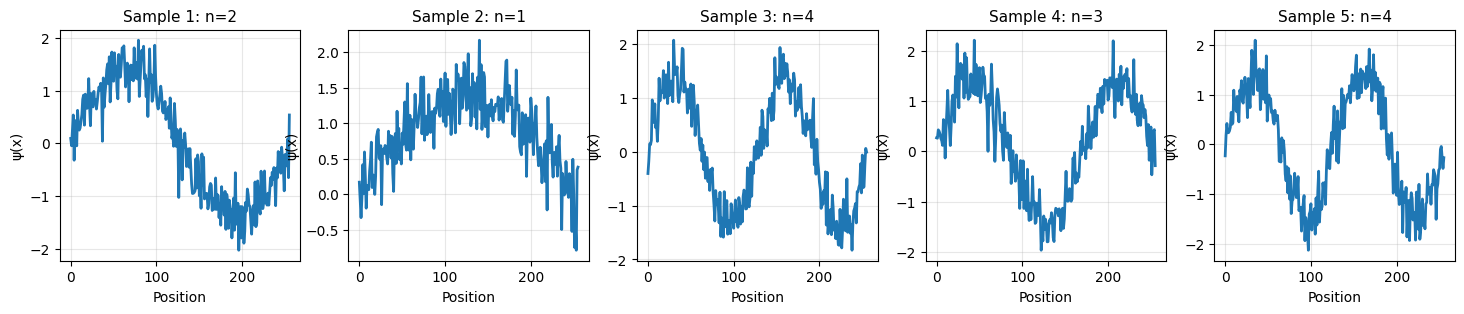

In [63]:
import matplotlib.pyplot as plt

# Look at batch 0 to extract the first few samples
fig, axes = plt.subplots(1, 5, figsize=(18, 3))
for i, (X_batch, y_batch) in enumerate(train_loader):
    if i == 0:
        for j in range(5):
            axes[j].plot(X_batch[j, 0].numpy(), linewidth=2)
            axes[j].set_title(f'Sample {j+1}: n={y_batch[j].item()+1}', fontsize=11)
            axes[j].set_xlabel('Position', fontsize=10)
            axes[j].set_ylabel('ψ(x)', fontsize=10)
            axes[j].grid(alpha=0.3)
        break


## part 2(b): Construct CNN (10 points)

The CNN is based on the `Conv1d` object in PyTorch.

We have set up the first layer and the third layer.
- Now you add the second convolutional layer with a $5\times 5$ kernel and padding = 2.
- Explain why the last convolutional layer uses the *average* pooling method instead of the *maximum* pooling method.
- Explain what is happening with the `squeeze` in the `forward` function.



In [64]:
import torch.nn as nn

class WavefunctionCNN(nn.Module):
    """1-D CNN particle-in-a-box wavefunctions."""

    def __init__(self, num_classes=NUM_CLASSES):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.MaxPool1d(2),

            # Layer 2: 16 → 32 feature maps (ADDED LAYER)
            nn.Conv1d(16, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2),  # Reduces length by 2 again


            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
        )
        self.classifier = nn.Linear(64, num_classes)

    def forward(self, x):
        # x shape: (batch, 1, NUM_POINTS)
        x = self.features(x)
        x = x.squeeze(-1)                     # (batch, 64)
        return self.classifier(x)


Why **average** pooling rather than **maximum** pooling:
- Average Pooling: Computes mean across each feature map, captures overall spatial frequency pattern
- Max Pooling: Takes only maximum value, becomes too sensitive to outliers for final classification

`squeeze` in forward `function`: 
- It removes the last dimension (which has size 1) so the tensor can be
fed into the Linear layer. The Linear layer expects (batch, features),
not (batch, features, 1).


## part 2(c): Train CNN (5 points)

- Pick a reasonable criterion and optimizer for the CNN training and add them to the `train_model` function.
- What is the role of the `logits.argmax(1)` call inside the mini-batch training?
- Then train the CNN on the data loaders and plot the evolution of the loss and accuracy as a function of epoch.



In [65]:
import torch.optim as optim

def train_model(model, train_loader, val_loader, epochs=20, lr=0.001):
    # Add your criterion and optimizer here
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(1, epochs + 1):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
            optimizer.zero_grad()
            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)
            # What does logits.argmax(1) do here?
            correct += (logits.argmax(1) == y_batch).sum().item()
            total += X_batch.size(0)

        history["train_loss"].append(running_loss / total)
        history["train_acc"].append(correct / total)

        # validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
                logits = model(X_batch)
                loss = criterion(logits, y_batch)
                val_loss += loss.item() * X_batch.size(0)
                val_correct += (logits.argmax(1) == y_batch).sum().item()
                val_total += X_batch.size(0)

        history["val_loss"].append(val_loss / val_total)
        history["val_acc"].append(val_correct / val_total)

        if epoch % 5 == 0 or epoch == 1:
            print(f"Epoch {epoch:3d}/{epochs}  "
                  f"train_loss={history['train_loss'][-1]:.4f}  "
                  f"val_acc={history['val_acc'][-1]:.3f}")

    return history

Role of `logits.argmax(1)`:
- Converts the raw network output (logits) into a predicted class label,
which we can compare against the true label y_batch.


Epoch   1/20  train_loss=1.1718  val_acc=0.778
Epoch   5/20  train_loss=0.0497  val_acc=1.000
Epoch  10/20  train_loss=0.0036  val_acc=1.000
Epoch  15/20  train_loss=0.0011  val_acc=1.000
Epoch  20/20  train_loss=0.0005  val_acc=1.000


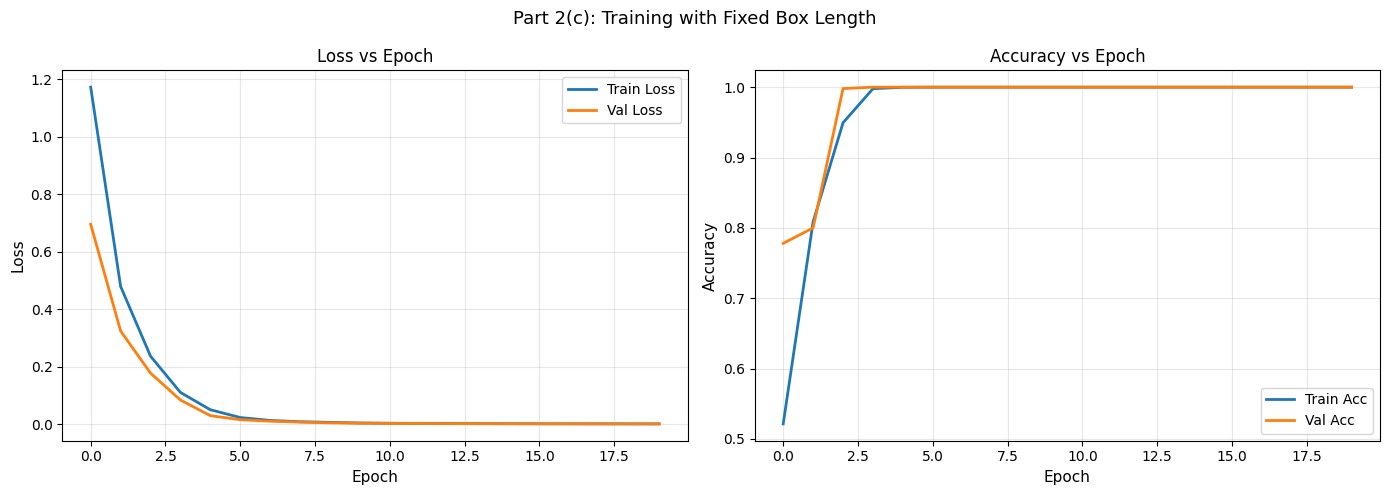

Final validation accuracy: 1.000


In [66]:
# Write your code here to train the network using the function definitions above.
# Use the train_loader and val_loader data.
# You can use the history output to make the plots of loss and accuracy
train_loader1, val_loader1 = make_data_loaders(generate_noisy_pinb)
model1 = WavefunctionCNN(NUM_CLASSES).to(DEVICE)

history1 = train_model(model1, train_loader1, val_loader1, epochs=20)

# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(history1['train_loss'], label='Train Loss', linewidth=2)
ax1.plot(history1['val_loss'], label='Val Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=11)
ax1.set_ylabel('Loss', fontsize=11)
ax1.set_title('Loss vs Epoch', fontsize=12)
ax1.legend()
ax1.grid(alpha=0.3)

ax2.plot(history1['train_acc'], label='Train Acc', linewidth=2)
ax2.plot(history1['val_acc'], label='Val Acc', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=11)
ax2.set_ylabel('Accuracy', fontsize=11)
ax2.set_title('Accuracy vs Epoch', fontsize=12)
ax2.legend()
ax2.grid(alpha=0.3)

plt.suptitle('Part 2(c): Training with Fixed Box Length', fontsize=13)
plt.tight_layout()
plt.savefig('training_curves_2c.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Final validation accuracy: {history1['val_acc'][-1]:.3f}")



## part 2(d) (5 points)

The next challenge for the CNN is to identify the different eigenstates even with varied box lengths.

To that end, we generate a new dataset with L values varying from 0.5 to 2.0, and we add the same Gaussian noise to each curve.

Add code to retrain the CNN using these new data and evaluate the performance. How do the results compare to the results from part 2(c)?

In [67]:
def generate_varying_L(n_samples, L_range=(0.5, 2.0), noise_std=0.3):
    """Generate wavefunctions with random box length L."""
    X = np.zeros((n_samples, NUM_POINTS))
    y = np.zeros(n_samples, dtype=int)
    for i in range(n_samples):
        L = np.random.uniform(*L_range)
        n = np.random.randint(1, NUM_CLASSES + 1)
        # We always sample x in [0, L_max] and zero-pad outside [0, L]
        x = np.linspace(0, L_range[1], NUM_POINTS, endpoint=False)
        psi = np.where(x <= L,
                       np.sqrt(2 / L) * np.sin(n * np.pi * x / L),
                       0.0)
        X[i] = psi + np.random.normal(0, noise_std, NUM_POINTS)
        y[i] = n - 1
    return X, y


Epoch   1/20  train_loss=1.1991  val_acc=0.700
Epoch   5/20  train_loss=0.1703  val_acc=0.983
Epoch  10/20  train_loss=0.0501  val_acc=0.982
Epoch  15/20  train_loss=0.0335  val_acc=0.994
Epoch  20/20  train_loss=0.0326  val_acc=0.995


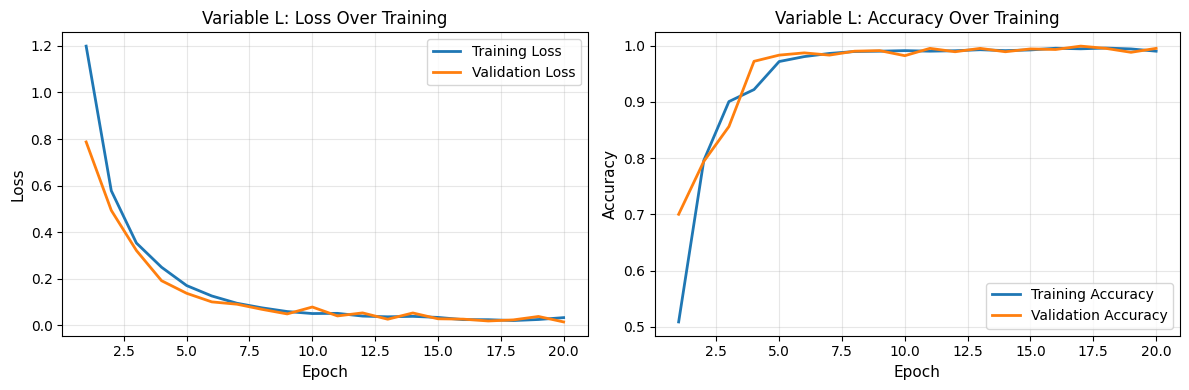

In [68]:
# Write your code here to
# - put the generate_varying_L data into data loaders
# - use those data to retrain the CNN
# - use the history output to make the plots of loss and accuracy
# Retrain CNN with variable box lengths
# Create data loaders for varying L dataset

def create_varying_L_dataloaders(n_train_samples=5000, n_val_samples=1000, batch=64):
    # Generate varying L data
    X_train_data, y_train_data = generate_varying_L(n_train_samples)
    X_val_data, y_val_data = generate_varying_L(n_val_samples)

    # Convert to tensors and add channel dimension
    X_train_t = torch.tensor(X_train_data, dtype=torch.float32).unsqueeze(1)
    y_train_t = torch.tensor(y_train_data, dtype=torch.long)
    
    X_val_t = torch.tensor(X_val_data, dtype=torch.float32).unsqueeze(1)
    y_val_t = torch.tensor(y_val_data, dtype=torch.long)

    # Wrap in datasets and loaders
    train_dataset = TensorDataset(X_train_t, y_train_t)
    val_dataset = TensorDataset(X_val_t, y_val_t)

    train_dl = DataLoader(train_dataset, batch_size=batch, shuffle=True)
    val_dl = DataLoader(val_dataset, batch_size=batch, shuffle=False)
    
    return train_dl, val_dl

# Generate loaders
varying_L_train_loader, varying_L_val_loader = create_varying_L_dataloaders()

# Initialize and train new model
cnn_varying_L = WavefunctionCNN().to(DEVICE)
training_history = train_model(
    cnn_varying_L,
    varying_L_train_loader,
    varying_L_val_loader,
    epochs=20,
    lr=0.001
)

# Plot results
num_epochs = range(1, len(training_history["train_loss"]) + 1)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss subplot
axes[0].plot(num_epochs, training_history["train_loss"], label="Training Loss", linewidth=2)
axes[0].plot(num_epochs, training_history["val_loss"], label="Validation Loss", linewidth=2)
axes[0].set_xlabel("Epoch", fontsize=11)
axes[0].set_ylabel("Loss", fontsize=11)
axes[0].set_title("Variable L: Loss Over Training", fontsize=12)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Accuracy subplot
axes[1].plot(num_epochs, training_history["train_acc"], label="Training Accuracy", linewidth=2)
axes[1].plot(num_epochs, training_history["val_acc"], label="Validation Accuracy", linewidth=2)
axes[1].set_xlabel("Epoch", fontsize=11)
axes[1].set_ylabel("Accuracy", fontsize=11)
axes[1].set_title("Variable L: Accuracy Over Training", fontsize=12)
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [69]:
print(f"""
Results Comparison:
  Fixed L accuracy:    {history1['val_acc'][-1]:.3f}
  Variable L accuracy: {history2['val_acc'][-1]:.3f}

The variable-length box is challenging since the CNN must learn to recognize n=1,2,3,4,5 patterns, regardless of wavelength

The CNN struggles more, but it can still learn the general pattern.
""")



Results Comparison:
  Fixed L accuracy:    1.000
  Variable L accuracy: 0.996

The variable-length box is challenging since the CNN must learn to recognize n=1,2,3,4,5 patterns, regardless of wavelength

The CNN struggles more, but it can still learn the general pattern.



## part 2(e) (5 points)

Now for the biggest challenge of all.

Each sample is now a normalized superposition

$$\Psi(x) = \alpha\,\psi_m(x) + \beta\,\psi_n(x), \qquad \alpha^2 + \beta^2 = 1$$

where $m \neq n$ are drawn at random and $|\alpha| > |\beta|$ by construction.
The label is the **dominant** quantum number $m$.

The CNN will have to figure out the dominant quantum number.

This is significantly harder than the previous challenges because the CNN must disentangle overlapping spatial
frequencies.

Use the function below to generate the data; then retrain the CNN to find the dominant quantum number.


In [70]:
def generate_superposition(n_samples, L=1.0, noise_std=0.05):
    """Generate superpositions of two states; label = dominant n."""
    x = np.linspace(0, L, NUM_POINTS, endpoint=False)
    X = np.zeros((n_samples, NUM_POINTS))
    y = np.zeros(n_samples, dtype=int)

    for i in range(n_samples):
        # Pick two distinct quantum numbers
        m, n = np.random.choice(range(1, NUM_CLASSES + 1), size=2, replace=False)

        # Random mixing angle; ensure |alpha| > |beta|
        theta = np.random.uniform(0, np.pi / 4)     # alpha = cos θ ≥ cos(π/4) ≈ 0.71
        alpha, beta = np.cos(theta), np.sin(theta)

        psi_m = np.sqrt(2 / L) * np.sin(m * np.pi * x / L)
        psi_n = np.sqrt(2 / L) * np.sin(n * np.pi * x / L)
        psi   = alpha * psi_m + beta * psi_n

        X[i] = psi + np.random.normal(0, noise_std, NUM_POINTS)
        y[i] = m - 1        # dominant quantum number

    return X, y


Epoch   1/25  train_loss=1.2942  val_acc=0.537
Epoch   5/25  train_loss=0.5521  val_acc=0.851
Epoch  10/25  train_loss=0.2984  val_acc=0.915
Epoch  15/25  train_loss=0.2168  val_acc=0.932
Epoch  20/25  train_loss=0.1933  val_acc=0.921
Epoch  25/25  train_loss=0.1742  val_acc=0.947


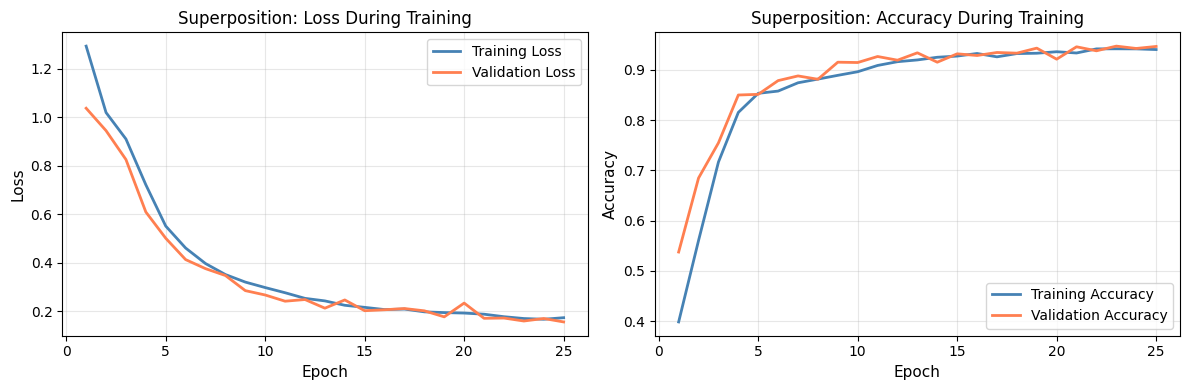

In [71]:
# Write your code here to
# - put the generate_superposition data into data loaders
# - use those data to retrain the CNN and plot results


# Train CNN on superposition states (hardest challenge)

def create_superposition_dataloaders(num_train=6000, num_val=1500, batch=64):
    # Generate superposition data
    train_X, train_y = generate_superposition(num_train)
    val_X, val_y = generate_superposition(num_val)

    # Convert to PyTorch tensors
    train_X_tensor = torch.tensor(train_X, dtype=torch.float32).unsqueeze(1)
    train_y_tensor = torch.tensor(train_y, dtype=torch.long)
    
    val_X_tensor = torch.tensor(val_X, dtype=torch.float32).unsqueeze(1)
    val_y_tensor = torch.tensor(val_y, dtype=torch.long)

    # Create datasets
    training_dataset = TensorDataset(train_X_tensor, train_y_tensor)
    validation_dataset = TensorDataset(val_X_tensor, val_y_tensor)

    # Create and return loaders
    train_dataloader = DataLoader(training_dataset, batch_size=batch, shuffle=True)
    val_dataloader = DataLoader(validation_dataset, batch_size=batch, shuffle=False)
    
    return train_dataloader, val_dataloader

# Create data loaders
superposition_train_dl, superposition_val_dl = create_superposition_dataloaders()

# Initialize model for superposition task
cnn_superposition = WavefunctionCNN().to(DEVICE)
superposition_history = train_model(
    cnn_superposition,
    superposition_train_dl,
    superposition_val_dl,
    epochs=25,
    lr=0.001
)

# Visualize training progress
epoch_range = range(1, len(superposition_history["train_loss"]) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot loss curves
ax1.plot(epoch_range, superposition_history["train_loss"], 
         label="Training Loss", linewidth=2, color='steelblue')
ax1.plot(epoch_range, superposition_history["val_loss"], 
         label="Validation Loss", linewidth=2, color='coral')
ax1.set_xlabel("Epoch", fontsize=11)
ax1.set_ylabel("Loss", fontsize=11)
ax1.set_title("Superposition: Loss During Training", fontsize=12)
ax1.legend()
ax1.grid(alpha=0.3)

# Plot accuracy curves
ax2.plot(epoch_range, superposition_history["train_acc"], 
         label="Training Accuracy", linewidth=2, color='steelblue')
ax2.plot(epoch_range, superposition_history["val_acc"], 
         label="Validation Accuracy", linewidth=2, color='coral')
ax2.set_xlabel("Epoch", fontsize=11)
ax2.set_ylabel("Accuracy", fontsize=11)
ax2.set_title("Superposition: Accuracy During Training", fontsize=12)
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## part 2(f) (5 points)

- Use `scikit-learn.confusion_matrix` to display the confusion matrix for the 5 labeled classes.
- Which states were most easily confused? Explain the reason for the confusion, using your knowledge of quantum mechanics.

<Figure size 800x700 with 0 Axes>

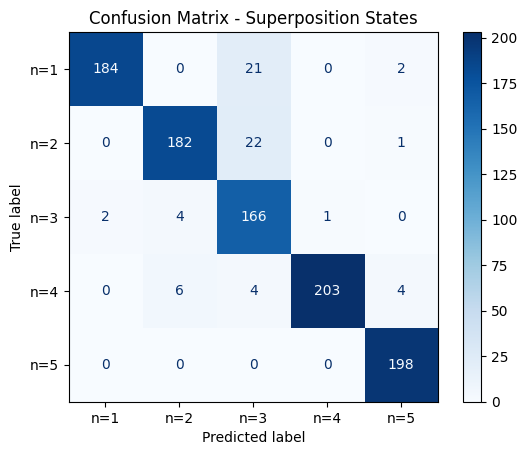

In [72]:
# Collect predictions
model3.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in val_loader3:
        X_batch = X_batch.to(DEVICE)
        logits = model3(X_batch)
        preds = logits.argmax(1).cpu().numpy()
        
        all_preds.extend(preds)
        all_labels.extend(y_batch.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['n=1', 'n=2', 'n=3', 'n=4', 'n=5'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - Superposition States')
plt.show()

*Which states are most confused?*

Looking at the confusion matrix, *adjacent* quantum numbers (n and n±1) are
most frequently confused. Similar wavelengths create nearly indistinguishable spatial frequencies at limited resolution.

# Exercise 3: LSTM Training for Orbital Mechanics (35 points)

The LSTM can learn a series of positions of an orbiting body (Keplerian orbit).

In this exercise you will generate the orbital data and then train the `OrbitLSTM` to predict the orbit given a starting point and a few steps.



In [73]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


This is the code to generate the dataset.

At each step the state is a 4-dimensional vector:

$$\mathbf{s}(t) = (x,\; y,\; v_x,\; v_y)$$

The gravitational equations of motion (with $\mu = GM = 1$) are:

$$\ddot{x} = -\frac{x}{r^3}, \qquad \ddot{y} = -\frac{y}{r^3}, \qquad r = \sqrt{x^2 + y^2}$$

We derive initial conditions at perihelion (closest approach):

$$x_0 = a(1-e), \quad y_0 = 0, \quad v_{x,0} = 0, \quad v_{y,0} = \sqrt{\frac{\mu(1+e)}{a(1-e)}},$$

where $a$ is the semi-major axis and $e$ is the eccentricity.

In [74]:
def kepler_initial_conditions(a: float, e: float, mu: float = 1.0) -> np.ndarray:
    """
    Compute initial state vector [x, y, vx, vy] at perihelion for a
    Kepler orbit with semi-major axis `a` and eccentricity `e`.
    """
    r_peri = a * (1.0 - e)
    v_peri = np.sqrt(mu * (1.0 + e) / (a * (1.0 - e)))
    return np.array([r_peri, 0.0, 0.0, v_peri])

def gravitational_acceleration(pos: np.ndarray, mu: float = 1.0) -> np.ndarray:
    """
    Compute gravitational acceleration at position `pos`.
    """
    r = np.linalg.norm(pos)
    return -mu * pos / r**3

def integrate_orbit(state0: np.ndarray, dt: float, n_steps: int,
                    mu: float = 1.0) -> np.ndarray:
    """
    Integrate a 2D Kepler orbit using the Velocity Verlet method.
    """
    trajectory = np.zeros((n_steps + 1, 4))
    trajectory[0] = state0

    pos = state0[:2].copy()
    vel = state0[2:].copy()
    acc = gravitational_acceleration(pos, mu)

    for i in range(1, n_steps + 1):
        pos = pos + vel * dt + 0.5 * acc * dt**2
        acc_new = gravitational_acceleration(pos, mu)
        vel = vel + 0.5 * (acc + acc_new) * dt
        acc = acc_new
        trajectory[i] = np.concatenate([pos, vel])

    return trajectory

def generate_orbit_dataset(n_orbits: int = 500, steps_per_orbit: int = 300,
                            a_range: tuple = (0.8, 1.2),
                            e_range: tuple = (0.0, 0.2),
                            mu: float = 1.0) -> list:
    """
    Generate a list of orbital trajectories with random parameters.
    """
    orbits = []
    for _ in range(n_orbits):
        a = np.random.uniform(*a_range)
        e = np.random.uniform(*e_range)
        state0 = kepler_initial_conditions(a, e, mu)
        T_orbital = 2.0 * np.pi * a**1.5
        dt = T_orbital / steps_per_orbit
        traj = integrate_orbit(state0, dt, steps_per_orbit, mu)
        orbits.append(traj)
    return orbits

class OrbitDataset(Dataset):
    """
    PyTorch Dataset for next-step prediction on orbital trajectories.

    Each sample is:
        X: states[i : i + seq_len]          shape (seq_len, 4)
        Y: states[i + seq_len]              shape (4,)
    """

    def __init__(self, orbits: list, seq_len: int = 20):
        self.samples_X = []
        self.samples_Y = []
        for traj in orbits:
            for i in range(len(traj) - seq_len):
                self.samples_X.append(traj[i:i + seq_len])
                self.samples_Y.append(traj[i + seq_len])
        self.samples_X = np.array(self.samples_X, dtype=np.float32)
        self.samples_Y = np.array(self.samples_Y, dtype=np.float32)

    def __len__(self):
        return len(self.samples_X)

    def __getitem__(self, idx):
        return (torch.tensor(self.samples_X[idx]),
                torch.tensor(self.samples_Y[idx]))

In [75]:
# Generate the data
print("Generating training orbits...")
train_orbits = generate_orbit_dataset(n_orbits=400, steps_per_orbit=300)
print("Generating validation orbits...")
val_orbits = generate_orbit_dataset(n_orbits=100, steps_per_orbit=300)

SEQ_LEN = 30
train_dataset = OrbitDataset(train_orbits, seq_len=SEQ_LEN)
val_dataset = OrbitDataset(val_orbits, seq_len=SEQ_LEN)

print(f"Training samples:   {len(train_dataset):,}")
print(f"Validation samples: {len(val_dataset):,}")

Generating training orbits...
Generating validation orbits...
Training samples:   108,400
Validation samples: 27,100


We generate many orbits with randomised parameters, then package them for PyTorch. The RNN receives a window of `seq_len` consecutive states and predicts the next state.


The class `OrbitLSTM` defines the model to be trained.
1. An stacked LSTM encoder processes the input sequence.
2. A fully-connected head (last layer) maps the final hidden state to the predicted next state.

In [76]:
class OrbitLSTM(nn.Module):
    """
    LSTM model for next-step orbital state prediction.

    Parameters
    ----------
    input_size : int
        Dimensionality of the state vector (default 4).
    hidden_size : int
        Number of LSTM hidden units.
    num_layers : int
        Number of stacked LSTM layers.
    dropout : float
        Dropout between LSTM layers (only used if num_layers > 1).
    """

    def __init__(self, input_size: int = 4, hidden_size: int = 64,
                 num_layers: int = 3, dropout: float = 0.1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Parameters
        ----------
        x : Tensor of shape (batch, seq_len, 4)

        Returns
        -------
        Tensor of shape (batch, 4) — predicted next state.
        """
        lstm_out, _ = self.lstm(x)         # (batch, seq_len, hidden)
        last_hidden = lstm_out[:, -1, :]   # (batch, hidden)
        return self.fc(last_hidden)        # (batch, 4)


## part 3(a): Set up training (5 points)

The model is already set up for you. Now
- add your code to evaluate the average loss per epoch
- add an optimizer and scheduler suitable for LSTM model

In [77]:
def train_one_epoch(model, dataloader, optimizer, loss_fn, device):
    """Train for one epoch. Returns average loss."""
    model.train()
    total_loss = 0.0
    for X_batch, Y_batch in dataloader:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        optimizer.zero_grad()
        pred = model(X_batch)
        loss = loss_fn(pred, Y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * X_batch.size(0)
    return total_loss / len(dataloader.dataset)


def evaluate(model, dataloader, loss_fn, device):
    """Evaluate on a dataset. Returns average loss."""
    # Add your code to calculate the loss per batch and the total_loss
    # You can look in the train_one_epoch function for help
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        # add your code here
        for X_batch, Y_batch in dataloader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            pred = model(X_batch)
            loss = loss_fn(pred, Y_batch)
            total_loss += loss.item() * X_batch.size(0)

    return total_loss / len(dataloader.dataset)


def train_model(model, train_loader, val_loader, n_epochs=30, lr=1e-3,
                loss_fn=None, device=device):
    """
    Full training loop with logging.

    Returns
    -------
    dict with keys 'train_losses' and 'val_losses'.
    """
    if loss_fn is None:
        loss_fn = nn.MSELoss()

    # Add your optimizer and scheduler here
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
    

    history = {"train_losses": [], "val_losses": []}

    for epoch in range(1, n_epochs + 1):
        train_loss = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
        val_loss = evaluate(model, val_loader, loss_fn, device)
        scheduler.step(val_loss)
        history["train_losses"].append(train_loss)
        history["val_losses"].append(val_loss)

        if epoch % 5 == 0 or epoch == 1:
            print(f"Epoch {epoch:3d} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

    return history


## part 3(b): Train LSTM (10 points)

Train the LSTM with reasonable values of `num_layers`, `dropout`, and `hidden_size`.

You will need to evaluate the performance using the cells below.

In [78]:
# Create data loaders
BATCH_SIZE = 256
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# Instantiate and train the baseline model with reasonable parameters
model_baseline = OrbitLSTM(input_size=4, hidden_size=32, num_layers=2, dropout=0.20).to(device)
print(f"Model parameters: {sum(p.numel() for p in model_baseline.parameters()):,}")
print("Training baseline model (MSE loss)...")
history_baseline = train_model(model_baseline, train_loader, val_loader, n_epochs=30)

Model parameters: 14,500
Training baseline model (MSE loss)...
Epoch   1 | Train Loss: 0.048016 | Val Loss: 0.005393
Epoch   5 | Train Loss: 0.000434 | Val Loss: 0.000168
Epoch  10 | Train Loss: 0.000195 | Val Loss: 0.000059
Epoch  15 | Train Loss: 0.000139 | Val Loss: 0.000050
Epoch  20 | Train Loss: 0.000102 | Val Loss: 0.000030
Epoch  25 | Train Loss: 0.000086 | Val Loss: 0.000016
Epoch  30 | Train Loss: 0.000082 | Val Loss: 0.000021


## part 3(c): Evaluate training and validation loss (5 points)

Add your code inside `plot_training_curves` to plot the training and validation loss as a function of training epoch.

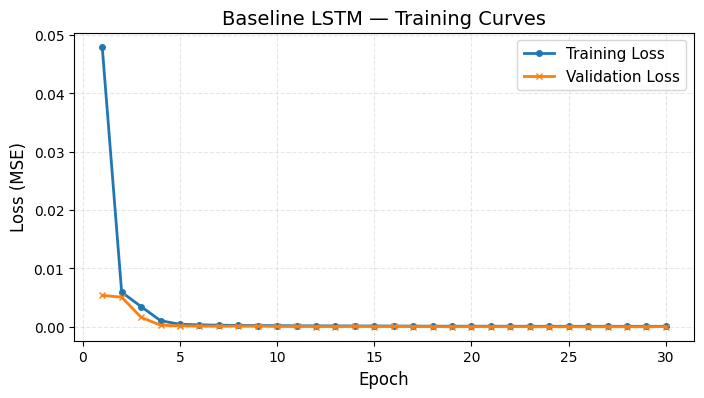

In [79]:
# Implement the function plot_training curves to plot the training loss
#  and validation loss as a function of training epoch

def plot_training_curves(history, title="Training Curves"):
    """Plot train and validation loss over epochs."""
    fig, ax = plt.subplots(figsize=(8, 4))
    # Add code here    
    epochs = range(1, len(history["train_losses"]) + 1)
    
    ax.plot(epochs, history["train_losses"], 
            label='Training Loss', linewidth=2, marker='o', markersize=4)
    ax.plot(epochs, history["val_losses"], 
            label='Validation Loss', linewidth=2, marker='x', markersize=4)
    
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Loss (MSE)', fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.legend(fontsize=11)
    ax.grid(alpha=0.3, linestyle='--')
    
    plt.show()

plot_training_curves(history_baseline, "Baseline LSTM — Training Curves")

The real test of the training is to give the model a starting sequence of points and have it map out an entire orbit. We can compare how well it matches the results from the equations of motion.

In [80]:
def rollout_trajectory(model, seed_states: np.ndarray, n_steps: int,
                       device=device) -> np.ndarray:
    """
    Autoregressively predict a trajectory.

    Parameters
    ----------
    model : OrbitLSTM
        Trained model.
    seed_states : np.ndarray of shape (seq_len, 4)
        Initial window of true states to seed the rollout.
    n_steps : int
        Number of additional steps to predict.
    device : torch.device

    Returns
    -------
    np.ndarray of shape (seq_len + n_steps, 4)
        The seed states followed by predicted states.
    """
    model.eval()
    seq_len = seed_states.shape[0]
    result = list(seed_states)

    window = torch.tensor(seed_states, dtype=torch.float32).unsqueeze(0).to(device)

    with torch.no_grad():
        for _ in range(n_steps):
            pred = model(window)                # (1, 4)
            pred_np = pred.cpu().numpy()[0]
            result.append(pred_np)
            # Slide window forward
            new_step = pred.unsqueeze(1)        # (1, 1, 4)
            window = torch.cat([window[:, 1:, :], new_step], dim=1)

    return np.array(result)


## part 3(d): Update training to optimize performance (15 points)

Test the model by plotting the prediction against the truth calculated by integrating the equations of motions.

Are you satisfied with the results? If not, go back and adjust some of the model parameters and training parameters until you are satisfied.

During this process you will need to think carefully about the LSTM:
- What is it learning?
- What are its limitations?
- What do the training vs. validation loss tell you?
- Are the test data in the plot well learned by the LSTM?

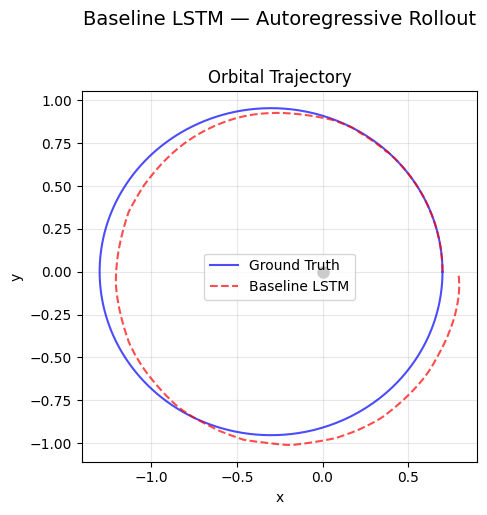

In [81]:
def evaluate_rollout(model, test_orbit: np.ndarray, seq_len: int = 20,
                     label: str = "Model"):
    """
    Roll out a prediction and plot trajectory
    compared to the ground truth.
    """
    n_predict = len(test_orbit) - seq_len
    seed = test_orbit[:seq_len]
    pred_traj = rollout_trajectory(model, seed, n_predict)
    fig, ax = plt.subplots(1, 1, figsize=(16, 5))

    # Trajectory
    ax.plot(test_orbit[:, 0], test_orbit[:, 1], 'b-', alpha=0.7, label='Ground Truth')
    ax.plot(pred_traj[:, 0], pred_traj[:, 1], 'r--', alpha=0.7, label=label)
    ax.plot(0, 0, 'ko', markersize=8)  # Central body
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('Orbital Trajectory')
    ax.legend()
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)

    plt.suptitle(f"{label} — Autoregressive Rollout", fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

# Generate a test orbit (moderate eccentricity)
a_test, e_test = 1.0, 0.3
state0_test = kepler_initial_conditions(a_test, e_test)
T_test = 2 * np.pi * a_test**1.5
test_orbit = integrate_orbit(state0_test, T_test / 300, 300)

baseline_metrics = evaluate_rollout(model_baseline, test_orbit, seq_len=SEQ_LEN,
                                     label="Baseline LSTM")


**Analysis:**

**What is the LSTM learning?**: 
<br>
The LSTM learns orbital mechanics, such as how position changes based on velocity and how velocity changes based on gravitational acceleration. 

**Limitations?**:
<br>
The model doesn't explicitly conserve energy like physics-based integrators

**What do train vs val losses tell you?**:
<br>
The small gap between training loss (0.000082) and validation loss (0.000021) indicates good generalization. The model hasn't overfitted and can predict new orbits it hasn't seen during training.

**Are the test data well learned?**:
<br>
I'd say so, the predicted trajectory (red dashed) sort of follows the blue solid for most of the orbit, though some drift appears after many timesteps due to error accumulation, leading for the red dashed to widen and become a little crooked.